# Deep learning

## Task 3.1: Create an Image Dataset

### A: Dataset Creation

I mainly used Generative AI (the Generating image dataset template) for my dataset and didn't use web scraping since I wanted my images to be more consistent (for each of the specific fruits and ripeness levels) and of good quality and on the web it was hard to come across such images so I decided to use mainly generative AI instead.

I used 400 images in total for 2 classes (unripe and ripe fruits) with 200 images per class. I used 4 different fruits (bananas, mangoes, oranges and strawberries) so that my dataset would be diverse.

### B: Dataset Cleaning

I performed a thorough visual inspection for all the fruits to make sure there was no duplicates or irrelevant images. When I was adding them I made sure to always generate a new image for each fruit such as (unripe: mango) then I checked through and made sure there were no duplicates then did the same thing for the next fruit (unripe: banana for example) and so on until all the fruits were done and the full image dataset was made. This procedure also naturally made sure at the same time no irrelevant images were there and all the images represented the correct classes.

The rest of the preprocessing (normalization, resizing, etc) will be done below

### C: Final Dataset

https://edubuas-my.sharepoint.com/:f:/g/personal/245086_buas_nl/Eu8-3Qgr3_pEjfs3kk3a3agB7XsoxFeZ-JR3rQS6a4cgHQ?e=TItkxH

### D: Load and Split

### Loading dataset

In [1]:
import os
import numpy as np
import skimage as ski

# Folder paths
folder_paths = [
    r"fruits_dataset_aryanjajoo\ripe",
    r"fruits_dataset_aryanjajoo\unripe"
]

# Class labels
class_labels = [
    "ripe",
    "unripe"
]

# Target size is 64x64 pixels
target_size = (64, 64)

X = []
y = []

for i in range(len(folder_paths)):

    for filename in os.listdir(folder_paths[i]):

        file_extension = os.path.splitext(filename)[1]

        if file_extension == ".jpg" or file_extension == ".jpeg" or file_extension == ".png": 
            image_filename = os.path.join(folder_paths[i], filename)

            # Resize image
            image = ski.io.imread(image_filename)
            image_resized = ski.transform.resize(image, target_size)

            # Insert image into array X and class label into array y
            X.append(image_resized)
            y.append(class_labels[i])

# Converting into numpy arrays
X = np.array(X)
y = np.array(y)

### Note: Images are already normalized from the previous section (as you can see below too)

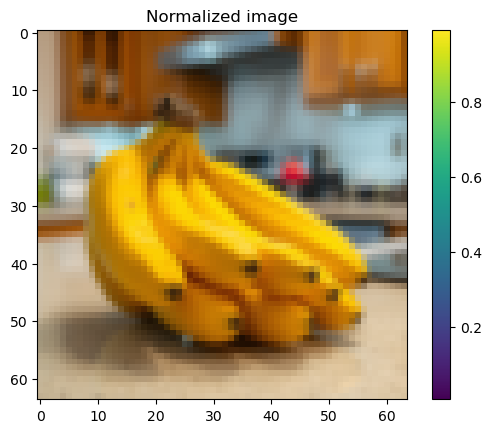

In [2]:
import matplotlib.pyplot as plt

# Picking a random image to show as an example
image = X[0]

# Display the image
plt.imshow(image)
plt.title("Normalized image")
plt.colorbar()
plt.show()

### Encoding

In [3]:
import sklearn as ski
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# Label encoding
label_encoder = LabelEncoder()

# Encoding
y_encoded = label_encoder.fit_transform(y)

# One hot encoding
y_onehot_encoded = keras.utils.to_categorical(y_encoded, num_classes=2)

### Splitting Dataset

In [4]:
from sklearn.model_selection import train_test_split

# Split image dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_onehot_encoded,
                                                    test_size = 1/10,
                                                    random_state = 0)
                                               
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(360, 64, 64, 3) (40, 64, 64, 3)
(360, 2) (40, 2)


In [5]:
# Validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 1/9,
                                                  random_state = 0)
                                                  
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(320, 64, 64, 3) (40, 64, 64, 3) (40, 64, 64, 3)
(320, 2) (40, 2) (40, 2)


## Task 3.2: Calculate Baselines

### A: Random Guess Accuracy

My dataset is balanced (it has the same amount of samples for each class) so the random guess accuracy is given by 100/n where n is the number of classes (in my case n=2).

100/n = 100/2 = 50%

#### **Random Guess Accuracy = 50%**

### B: Basic Multilayer Perceptron Accuracy

#### I: Preprocessing

No preprocessing was needed as all the preprocessing was already **done previously.**

**This includes:**
- Resizing and cropping images to standardize their resolution (64x64 pixels)
- Consistent format (all images are PNG)
- Resizing of images (to 64x64 size)
- Normalization
- No mislabeled images
- Checked for duplicates
- One hot encoding
- Splitting dataset into training, validation and test sets
- and more

#### II: MLP Architecture 

I chose a simple layout for my MLP since it was the first model and I can always perform improvements later with the CNN iterations coming up. I chose a small amount of neurons since more neurons quickly led to overfitting, and my dataset is also very small with only 2 classes so it was difficult to work against overfitting.

I first flattened the input image to be suitable to use, then I added some hidden layers and finally an output layer with 2 outputs, with softmax activation.

Note: I used softmax instaed of sigmoid even though I only have 2 classes because I one hot encoded my labels so I will be doing mult-class classification instead of binary classification.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

mlp = Sequential([
        # Flatten layer
        Flatten(input_shape=(64, 64, 3)),

        # Hidden layers
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),

        # Output layer
        Dense(2, activation='softmax')
])

# Model summary
mlp.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 10)                122890    
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 122957 (480.30 KB)
Trainable params: 122957 (480.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### III: MLP Training

In [7]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Compile
mlp.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Fit model
training = mlp.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=30,
          batch_size=30,
          callbacks=[early_stopping])

# History
history = training.history

Epoch 1/30


11/11 [==============================] - 4s 76ms/step - loss: 0.6911 - accuracy: 0.5281 - val_loss: 0.6419 - val_accuracy: 0.7500
Epoch 2/30
11/11 [==============================] - 0s 17ms/step - loss: 0.6563 - accuracy: 0.6781 - val_loss: 0.6168 - val_accuracy: 0.7250
Epoch 3/30
11/11 [==============================] - 0s 17ms/step - loss: 0.6380 - accuracy: 0.6500 - val_loss: 0.5934 - val_accuracy: 0.7500
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 0.6135 - accuracy: 0.6656 - val_loss: 0.5912 - val_accuracy: 0.8000
Epoch 5/30
11/11 [==============================] - 0s 17ms/step - loss: 0.5915 - accuracy: 0.7156 - val_loss: 0.5644 - val_accuracy: 0.8000
Epoch 6/30
11/11 [==============================] - 0s 17ms/step - loss: 0.5765 - accuracy: 0.7656 - val_loss: 0.5487 - val_accuracy: 0.8500
Epoch 7/30
11/11 [==============================] - 0s 13ms/step - loss: 0.5580 - accuracy: 0.7781 - val_loss: 0.5543 - val_accuracy: 0.8750
Epoch 8/30


#### IV: MLP Evaluation

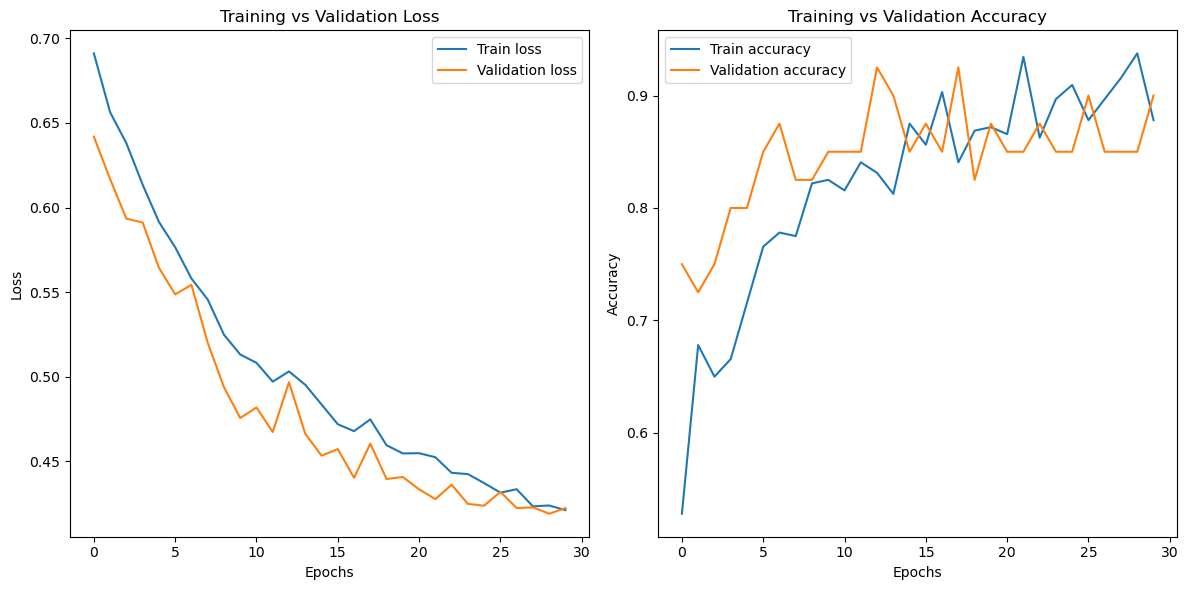

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history['loss'], label='Train loss')
axes[0].plot(history['val_loss'], label='Validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history['accuracy'], label='Train accuracy')
axes[1].plot(history['val_accuracy'], label='Validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Evaluation
loss, accuracy = mlp.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 [==============================] - 0s 5ms/step - loss: 0.5155 - accuracy: 0.8750
Test Loss: 0.5154889822006226
Test Accuracy: 0.875


### Testing different learning rates

In [10]:
# Different learning rates to test out
learning_rates = [0.1, 0.001, 0.0001]
results = {}

# Loop that goes through all learning rates individually with baseline MLP model
for rate in learning_rates:

    print(f"Learning rate: {rate}")

    mlp = Sequential([
        # Input layer
        Flatten(input_shape=(64, 64, 3)),

        # Hidden layers
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        
        # Output layer
        Dense(2, activation='softmax')
    ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # Compile model with learning rate
    mlp.compile(
        optimizer=Adam(learning_rate=rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fit the model
    training = mlp.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=30,
                         batch_size=30,
                         callbacks=[early_stopping])

    # Store results
    loss, acc = mlp.evaluate(X_test, y_test)
    results[rate] = (loss, acc)


Learning rate: 0.1
Epoch 1/30
11/11 [==============================] - 2s 46ms/step - loss: 156.0264 - accuracy: 0.4781 - val_loss: 0.7380 - val_accuracy: 0.3750
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 0.7023 - accuracy: 0.5031 - val_loss: 0.7145 - val_accuracy: 0.3750
Epoch 3/30
11/11 [==============================] - 0s 13ms/step - loss: 0.6949 - accuracy: 0.4781 - val_loss: 0.6819 - val_accuracy: 0.6250
Epoch 4/30
11/11 [==============================] - 0s 14ms/step - loss: 0.6988 - accuracy: 0.4969 - val_loss: 0.6848 - val_accuracy: 0.6250
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 0.6945 - accuracy: 0.5094 - val_loss: 0.7212 - val_accuracy: 0.3750
Epoch 6/30
11/11 [==============================] - 0s 13ms/step - loss: 0.6951 - accuracy: 0.4906 - val_loss: 0.6855 - val_accuracy: 0.6250
Epoch 7/30
11/11 [==============================] - 0s 12ms/step - loss: 0.6963 - accuracy: 0.4656 - val_loss: 0.6950 - val_accuracy:

In [11]:
import pandas as pd

# Convert dictionary into a dataframe
mlp_results = pd.DataFrame.from_dict(results, orient='index', columns=['Test Loss', 'Test Accuracy'])

# Moves index (learning rates currently) into a regular column
mlp_results.reset_index(inplace=True)

# Rename
mlp_results.rename(columns={'index': 'Learning Rate'}, inplace=True)

In [12]:
mlp_results

,Learning Rate,Test Loss,Test Accuracy
0,0.1000,0.718610,0.40
1,0.0010,0.416830,0.85
2,0.0001,0.339917,0.90


The best learning rate is **0.0001** from the results, which is why I used it above and I will use a learning rate of 0.0001 as my learning rate across the CNNs.

### **The final accuracy obtained with the Basic MLP model is 87.5%**

### C: Human-Level Performance Accuracy

I made a quiz on microsoft forms with 30 images of fruits where 15 ripe and 15 unripe fruits were jumbled up and people were asked to simply say if they think the fruit they see per question is unripe or ripe.

Here is the [Microsoft form](https://forms.office.com/e/r8CvaKx4rZ) I used. 

I got 7 responses in total.

The average score was **27.6/30** which is equal to 0.92 or 92%

### **Human-Level Performance Accuracy: 92%**

## Task 3.3: Basic Convolutional Neural Network (Iteration 1)

### A: Preprocessing

No preprocessing was needed as all the preprocessing was already **done previously.**

**This includes:**
- Resizing and cropping images to standardize their resolution (64x64 pixels)
- Consistent format (all images are PNG)
- Resizing of images (to 64x64 size)
- Normalization
- No mislabeled images
- Checked for duplicates
- One hot encoding
- Splitting dataset into training, validation and test sets
- and more

### B: CNN Architecture

For the architecture I chose a dropout rate of 0.3, with 2 convolutional layers with max pooling in each along with dropout. I then added a flatten layer then added 2 dense layers with batch normalization and dropout after each dense layer to help prevent overfitting. Finally in the end I have an output layer with softmax since I'm doing multi class classification.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# Dropout rate
d = 0.3

cnn1 = Sequential([
    # Convolutional layer 1
    Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 3), padding='same'),
    MaxPool2D(2),
    Dropout(d),

    # Convolutional layer 2
    Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(2),
    Dropout(d),

    # Flatten
    Flatten(),

    # Dense layer 1
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(d),
    
    # Dense layer 2
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(d),

    # Output layer
    Dense(2, activation='softmax')
])

cnn1.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 8)       

### C: CNN Training

My strategy was to use the Adam optimizer with a learning rate of 0.0001 (which I found to be the most stable and best to use). I chose Adam as the optimizer since it worked best in helping the model converge efficiently while maintaining stability as well.

I used the categorical cross-entropy loss function. I did not use binary cross-entropy (even though I have 2 classes) since I decided to do 2 seperate classes with the softmax activation function and since this is a multi class classification problem I used categorical cross-entropy.

I also decided to use early stopping to help prevent unnecessary training and overfitting. I also used a patience of 20 for early stopping, which gave better results than some lower patience numbers. I needed to give my model some time to improve and learn and this patience level was the best for me, this way the model gets a fair chance to converge properly (since I already also have a small dataset).

After a lot of testing I found batch size of 30 to be a really good amount to work with. I used 30 epochs because it provided sufficient training time for the model to learn patterns from the dataset while avoiding excessive training that could lead to overfitting. 

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=18)

# Compile
cnn1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit model
training = cnn1.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping],
          epochs=30,
          batch_size=30)

# History
history = training.history

Epoch 1/30
11/11 [==============================] - 4s 80ms/step - loss: 1.0899 - accuracy: 0.5312 - val_loss: 0.7093 - val_accuracy: 0.4000
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 1.1615 - accuracy: 0.4437 - val_loss: 0.6924 - val_accuracy: 0.5500
Epoch 3/30
11/11 [==============================] - 0s 37ms/step - loss: 1.0278 - accuracy: 0.4938 - val_loss: 0.6886 - val_accuracy: 0.5500
Epoch 4/30
11/11 [==============================] - 0s 37ms/step - loss: 1.0702 - accuracy: 0.5437 - val_loss: 0.6823 - val_accuracy: 0.5250
Epoch 5/30
11/11 [==============================] - 0s 33ms/step - loss: 1.0630 - accuracy: 0.5312 - val_loss: 0.6795 - val_accuracy: 0.6250
Epoch 6/30
11/11 [==============================] - 0s 36ms/step - loss: 1.0358 - accuracy: 0.5063 - val_loss: 0.6725 - val_accuracy: 0.6500
Epoch 7/30
11/11 [==============================] - 0s 30ms/step - loss: 0.9338 - accuracy: 0.6062 - val_loss: 0.6630 - val_accuracy: 0.6500
Epoch 8/30
11

### D: Model Evaluation

Here is my plan to evaluate the CNN model:

**Plot Curves:**
- Training vs validation loss curves
- Training vs validation accuracy curves

Evaluate **test loss** and **test accuracy.**

Generate **predictions** and create **y_pred and y_true** for further evaluations:
- Plot the confusion matrix

Then evaluate other metrics:
- precision
- recall 
- f1-score

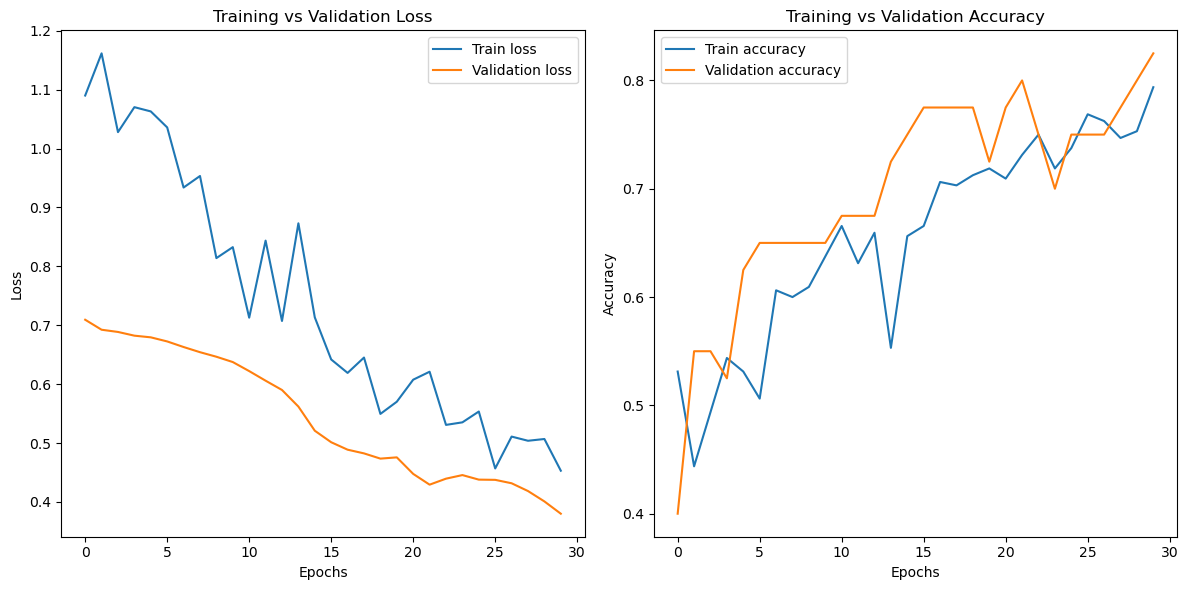

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history['loss'], label='Train loss')
axes[0].plot(history['val_loss'], label='Validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history['accuracy'], label='Train accuracy')
axes[1].plot(history['val_accuracy'], label='Validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Evaluation
loss_cnn1, accuracy_cnn1 = cnn1.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {accuracy_cnn1}")

2/2 [==============================] - 0s 19ms/step - loss: 0.4288 - accuracy: 0.7500
Test Loss: 0.42878493666648865
Test Accuracy: 0.75


2/2 [==============================] - 0s 10ms/step


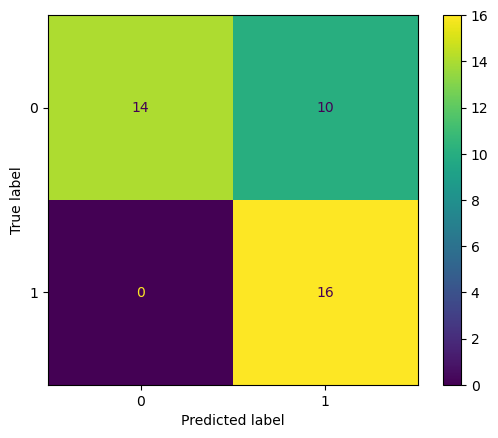

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = cnn1.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# More evaluation metrics (precision, recall and f1-score)
precision_cnn1 = precision_score(y_true, y_pred, average='macro')
recall_cnn1 = recall_score(y_true, y_pred, average='macro')
f1_cnn1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision_cnn1}")
print(f"Recall: {recall_cnn1}")
print(f"F1 Score: {f1_cnn1}")

Precision: 0.8076923076923077
Recall: 0.7916666666666667
F1 Score: 0.7493734335839599


## **Comparison of results against baselines**

The final accuracy of my CNN (iteration 1) was **75%**

- Random Guess Accuracy: 50%
- The final accuracy of my Basic MLP: 87.5%
- Human-Level Performance Accuracy: 92%

I feel like the final accuracy of my CNN (iteration 1) was not as good as I hoped, the performance of the CNN was better than the random guess accuracy however CNN was worse than the human level performance but I expected that for the first iteration since humans are naturally good at classifying unripe and ripe fruits so I hope to improve my CNN in the further iterations.

The CNN was also worse than my **basic MLP** likely because CNNs are more complex and may have struggled more compared to a simple model like my MLP because my dataset is also very small with only 2 classes. 

I believe since my dataset is also very small, with 400 images and only 2 classes, which made it a bit challenging to achieve consistently stable results.

I genuinely do think that data augmentation should definitely improve the accuracy since expanding my dataset would help my model generalize better and reduce overfitting. Since overfitting seems to be a very big problem right now, and I believe data augmentation is perfect to deal with such an issue.

## Task 3.4: Data Augmentation (Iteration 2)

### A: Preprocessing

As you know all the preprocessing was done beforehand.

In this iteration, the only extra preprocessing I will perform is for data augmentation. I will expand my dataset by applying augmentations to my current dataset.

Below I have put comments under the various steps I took to expand my dataset using data augmentation.

In [21]:
import keras
from keras import layers
import numpy as np

# Applies Data augmentation by randomly flipping, rotating and zooming images to create variations
# which will be used to expand my dataset

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
    ]
)

# Lists to store augmented images
X_aug = []
y_aug = []

# Number of augmentations per image
num_images = 3

# Applies augmentations per image and stores them
for i in range(len(X_train)):

    image = X_train[i]
    label = y_train[i]

    # Reshape
    image = np.reshape(image, (1,) + image.shape)

    for _ in range(num_images):
        # Apply augmentation
        augmented = data_augmentation(image)

        # Append augmented image and its respective label
        X_aug.append(augmented[0])
        y_aug.append(label)


# Convert to NumPy arrays
augmented_images = np.array(X_aug)
augmented_labels = np.array(y_aug)

# Recombine with original data to create the full expanded dataset
X_augmented_total = np.concatenate([X_train, augmented_images])
y_augmented_total = np.concatenate([y_train, augmented_labels])

### B: CNN Architecture

For iteration 2, I used the same architecture as iteration 1, since I need to test whether data augmentation helps or not, so there's no difference here

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# Dropout rate
d = 0.3

cnn2 = Sequential([
    # Convolutional layer 1
    Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 3), padding='same'),
    MaxPool2D(2),
    Dropout(d),

    # Convolutional layer 2
    Conv2D(8, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(2),
    Dropout(d),

    # Flatten
    Flatten(),

    # Dense layer 1
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(d),
    
    # Dense layer 2
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(d),

    # Output layer
    Dense(2, activation='softmax')
])

cnn2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 16, 16, 8)       

### C: CNN Training

I did the exact same thing as the iteration 1, since they both needed to be the same to truly see if data augmentation makes the evaluation process, curves and accuracies better or worse. I used early stopping with a patience of 18, Adam optimizer with a learning rate of 0.0001, 30 epochs and 30 as my batch size. 

However the only change was that instead of fitting the X_train and y_train sets, I used X_augmented_total and y_augmented_total (my expanded train set and labels using data augmentation).

In [35]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=18)

# Compile
cnn2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit model
training = cnn2.fit(X_augmented_total, y_augmented_total, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping],
          epochs=30,
          batch_size=30)

# History
history = training.history

Epoch 1/30
43/43 [==============================] - 2s 14ms/step - loss: 1.0376 - accuracy: 0.5141 - val_loss: 0.7126 - val_accuracy: 0.4500
Epoch 2/30
43/43 [==============================] - 0s 10ms/step - loss: 0.9118 - accuracy: 0.5742 - val_loss: 0.6619 - val_accuracy: 0.5250
Epoch 3/30
43/43 [==============================] - 0s 10ms/step - loss: 0.8534 - accuracy: 0.5875 - val_loss: 0.6228 - val_accuracy: 0.6250
Epoch 4/30
43/43 [==============================] - 1s 14ms/step - loss: 0.8012 - accuracy: 0.6016 - val_loss: 0.5770 - val_accuracy: 0.6250
Epoch 5/30
43/43 [==============================] - 1s 22ms/step - loss: 0.6999 - accuracy: 0.6523 - val_loss: 0.5374 - val_accuracy: 0.6750
Epoch 6/30
43/43 [==============================] - 1s 25ms/step - loss: 0.6766 - accuracy: 0.6695 - val_loss: 0.5119 - val_accuracy: 0.7000
Epoch 7/30
43/43 [==============================] - 1s 21ms/step - loss: 0.6204 - accuracy: 0.6836 - val_loss: 0.4642 - val_accuracy: 0.7750
Epoch 8/30
43

### D: Model Evaluation

Here is my plan to evaluate the CNN model:

**Plot Curves:**
- Training vs validation loss curves
- Training vs validation accuracy curves

Evaluate **test loss** and **test accuracy.**

Generate **predictions** and create **y_pred and y_true** for further evaluations:
- Plot the confusion matrix

Then evaluate other metrics:
- precision
- recall 
- f1-score

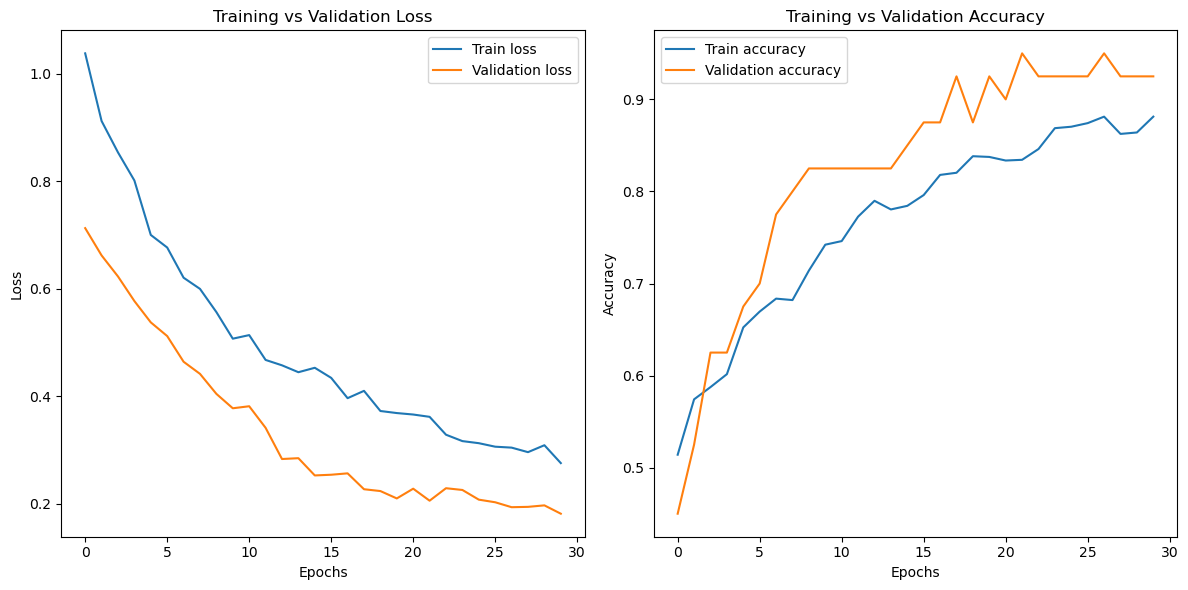

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history['loss'], label='Train loss')
axes[0].plot(history['val_loss'], label='Validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history['accuracy'], label='Train accuracy')
axes[1].plot(history['val_accuracy'], label='Validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [37]:
# Evaluation
loss_cnn2, accuracy_cnn2 = cnn2.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {accuracy_cnn2}")

2/2 [==============================] - 0s 13ms/step - loss: 0.1543 - accuracy: 0.9000
Test Loss: 0.15431006252765656
Test Accuracy: 0.8999999761581421


2/2 [==============================] - 0s 0s/step


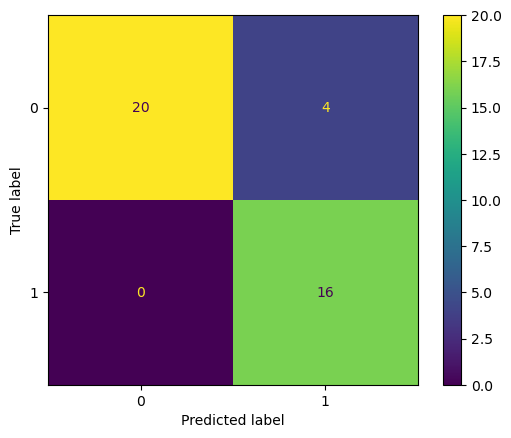

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = cnn2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# More evaluation metrics (precision, recall and f1-score)
precision_cnn2 = precision_score(y_true, y_pred, average='macro')
recall_cnn2 = recall_score(y_true, y_pred, average='macro')
f1_cnn2 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision_cnn2}")
print(f"Recall: {recall_cnn2}")
print(f"F1 Score: {f1_cnn2}")

Precision: 0.9
Recall: 0.9166666666666667
F1 Score: 0.898989898989899


## **Comparison of Results**

The results with data augmentation was better than iteration 1 of my CNN (which was without data augmentation)

- CNN (iteration 1) accuracy: 75%
- CNN (iteration 2) accuracy: 90%

The loss and accuracy curves were far better as well as the final accuracy, that means my model didn't overfit that much compared to iteration 1, showing data augmentation helped quite a lot to reduce overfitting. My accuracy was higher than iteration 1. Both of these aspects suggest data augmentation was a better decision for my CNN.

## Task 3.5: Transfer Learning (Iteration 3)

### A: Preprocessing

No preprocessing was needed as all the preprocessing was already **done previously.**

**This includes:**
- Resizing and cropping images to standardize their resolution (64x64 pixels)
- Consistent format (all images are PNG)
- Resizing of images (to 64x64 size)
- Normalization
- No mislabeled images
- Checked for duplicates
- One hot encoding
- Splitting dataset into training, validation and test sets
- and more

### B: CNN Architecture

For transfer learning I decided to use far fewer neurons and a different structure compared to the previous 2 iterations because the previous structure doesn't work well at all with my transfer learning base model.

I first used mobile net as my base model then froze the weights of the convolutional base. After that I created my cnn for iteration 3. First I added the base mobile net model then added a flatten layer. After that I added my hidden layers and used a higher dropout than before, but only once this time, because it seemed to work far better in this architecture, then finally I did my output layer. This structure proved to be very effective after a lot of testing so I decided to use it.

In [40]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten

d = 0.4

base_model = keras.applications.MobileNet(
                include_top=False,
                weights='imagenet',
                input_shape=(64, 64, 3))

# Freezes the weights of the convolutional base
base_model.trainable = False

cnn3 = Sequential([
        # Add the base model to the extended model
        base_model,

        # Flatten
        Flatten(),

        # Hidden layers
        Dense(10, activation='relu'),

        Dropout(d),
        
        Dense(5, activation='relu'),

        # Output
        Dense(2, activation='softmax')
])

cnn3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_27 (Dense)            (None, 10)                40970     
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_28 (Dense)            (None, 5)                 55        
                                                                 
 dense_29 (Dense)            (None, 2)                 12        
                                                     

### C: CNN Training

I again did the same 0.0001 learning rate (which I found to be the best for me), combined with the Adam optimizer (which worked better than SGD when I tested).

I also used a patience of 18 for early stopping, which gave better results than some lower patience numbers. I needed to give my model some time to improve and learn and this patience level was the best for me, this way the model gets a fair chance to converge properly (since I already also have a small dataset).

After some testing, 30 epochs and a batch size of 30 were again very good for my model, they seemed to work really well.

In [41]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=18)

# Compile
cnn3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit model
training = cnn3.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping],
          epochs=30,
          batch_size=30)

# History
history = training.history

Epoch 1/30
11/11 [==============================] - 3s 120ms/step - loss: 0.9480 - accuracy: 0.5094 - val_loss: 0.7272 - val_accuracy: 0.4500
Epoch 2/30
11/11 [==============================] - 1s 48ms/step - loss: 0.7082 - accuracy: 0.5594 - val_loss: 0.6648 - val_accuracy: 0.5500
Epoch 3/30
11/11 [==============================] - 1s 56ms/step - loss: 0.6740 - accuracy: 0.5531 - val_loss: 0.6770 - val_accuracy: 0.5250
Epoch 4/30
11/11 [==============================] - 1s 62ms/step - loss: 0.6561 - accuracy: 0.5375 - val_loss: 0.6512 - val_accuracy: 0.5500
Epoch 5/30
11/11 [==============================] - 1s 62ms/step - loss: 0.6178 - accuracy: 0.5750 - val_loss: 0.6175 - val_accuracy: 0.5500
Epoch 6/30
11/11 [==============================] - 1s 63ms/step - loss: 0.6087 - accuracy: 0.6125 - val_loss: 0.6039 - val_accuracy: 0.5750
Epoch 7/30
11/11 [==============================] - 1s 64ms/step - loss: 0.5525 - accuracy: 0.6938 - val_loss: 0.5733 - val_accuracy: 0.6000
Epoch 8/30
1

### D: Model Evaluation

Here is my plan to evaluate the CNN model:

**Plot Curves:**
- Training vs validation loss curves
- Training vs validation accuracy curves

Evaluate **test loss** and **test accuracy.**

Generate **predictions** and create **y_pred and y_true** for further evaluations:
- Plot the confusion matrix

Then evaluate other metrics:
- precision
- recall 
- f1-score

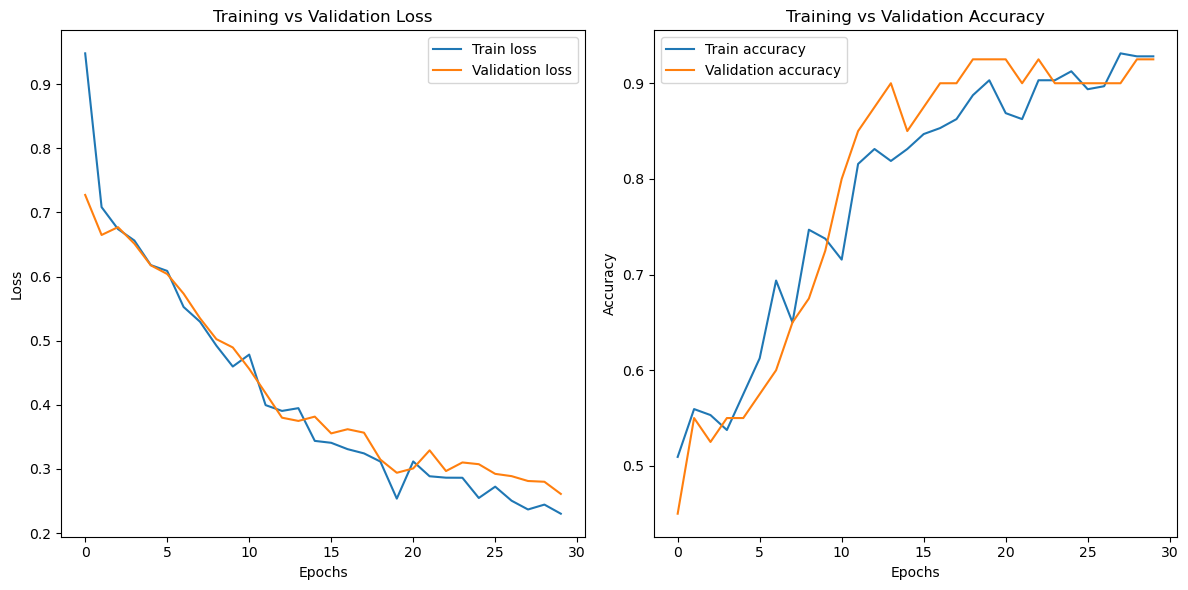

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history['loss'], label='Train loss')
axes[0].plot(history['val_loss'], label='Validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history['accuracy'], label='Train accuracy')
axes[1].plot(history['val_accuracy'], label='Validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [43]:
# Evaluation
loss_cnn3, accuracy_cnn3 = cnn3.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {accuracy_cnn3}")

2/2 [==============================] - 0s 33ms/step - loss: 0.1760 - accuracy: 0.9250
Test Loss: 0.17598886787891388
Test Accuracy: 0.925000011920929


2/2 [==============================] - 0s 20ms/step


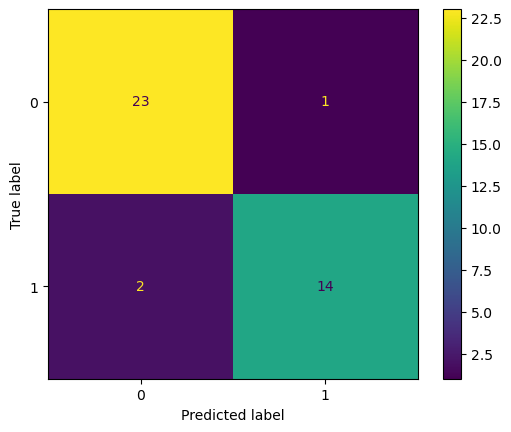

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = cnn3.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

# More evaluation metrics (precision, recall and f1-score)
precision_cnn3 = precision_score(y_true, y_pred, average='macro')
recall_cnn3 = recall_score(y_true, y_pred, average='macro')
f1_cnn3 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision_cnn3}")
print(f"Recall: {recall_cnn3}")
print(f"F1 Score: {f1_cnn3}")

Precision: 0.9266666666666667
Recall: 0.9166666666666667
F1 Score: 0.9210006583278473


## **Comparison of results**

- CNN (iteration 1) accuracy: 75%
- CNN (iteration 2) accuracy: 90%
- CNN (iteration 3) accuracy: 92.5%

My cnn for iteration 3 that used Transfer Learning did suprisingly well. I didn't expect transfer learning to be so effective, I will likely use it for my final iteration since even though it didn't make much of a difference compared to iteration 2 which used data augmentation (even though transfer learning didn't), and it still outscored my iteration 1 CNN suggesting it to be more effective.

## Task 3.6: Model Improvement (Iteration 4)

### A: Preprocessing

No preprocessing was needed as all the preprocessing was already **done previously.**

**This includes:**
- Resizing and cropping images to standardize their resolution (64x64 pixels)
- Consistent format (all images are PNG)
- Resizing of images (to 64x64 size)
- Normalization
- No mislabeled images
- Checked for duplicates
- One hot encoding
- Splitting dataset into training, validation and test sets
- and more

This iteration also uses data augmentation which was also done previously in iteration 2

### B: CNN Architecture

I decided to combine transfer learning with data augmentation for the final iteration. I think this is the best approach since transfer learning went really well and data augmentation also proved to be very useful in iteration 2.

I decided to slightly tweak the architecture for my final cnn model, I first used mobile net as my base model, then added it to my cnn4 (which is my extended model). I then added a flatten layer and did a combination of a dense layer followed by dropout of 0.15 (I found that with batch normalization it was better to go for a lower dropout rate) and batch normalization and repeated it with decreasing neurons per dense layer.

In [50]:
from tensorflow import keras

# Dropout value
d = 0.15

# Mobile net (using transfer learning)
base_model = keras.applications.MobileNet(
                include_top=False,
                weights='imagenet',
                input_shape=(64, 64, 3))

# Freezes the weights of the convolutional base
base_model.trainable = False

cnn4 = Sequential([
        # Added the base model to the extended model
        base_model,

        Flatten(),

        Dense(32, activation='relu'),

        Dropout(d),
        BatchNormalization(),
        
        Dense(16, activation='relu'),
        
        Dropout(d),
        BatchNormalization(),

        Dense(10, activation='relu'),
        
        Dropout(d),
        BatchNormalization(),

        # Output
        Dense(2, activation='softmax')
])

cnn4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 4096)              0         
                                                                 
 dense_34 (Dense)            (None, 32)                131104    
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_13 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 16)              

### C: CNN Training

I again did the same 0.0001 learning rate for the last iteration (which I found to be the best for me), combined with the Adam optimizer (which worked better than SGD when I tested again).

I also used a patience of 18 for early stopping, which gave better results than some lower patience numbers. I needed to give my model some time to improve and learn and this patience level was the best for me, this way the model gets a fair chance to converge properly (since I already also have a small dataset).

After some testing, 30 epochs and a batch size of 30 were again very good for my model, they seemed to work really well.

**The difference between iteration 3 and 4**:

I used the dataset which I expanded with data augmentation for the final iteration, whilst in iteration 3 I used the regular X_train and y_train sets. Data augmentation proved to be better so I decided to incorporate both transfer learning and data augmentation for my final iteration.

In [51]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=18)

# Compile
cnn4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit model
training = cnn4.fit(X_augmented_total, y_augmented_total, 
          validation_data=(X_val, y_val), 
          callbacks=[early_stopping],
          epochs=30,
          batch_size=30)

# History
history = training.history

Epoch 1/30
43/43 [==============================] - 6s 81ms/step - loss: 0.6750 - accuracy: 0.6141 - val_loss: 0.5205 - val_accuracy: 0.6500
Epoch 2/30
43/43 [==============================] - 2s 50ms/step - loss: 0.5546 - accuracy: 0.7164 - val_loss: 0.4659 - val_accuracy: 0.8000
Epoch 3/30
43/43 [==============================] - 3s 65ms/step - loss: 0.5209 - accuracy: 0.7445 - val_loss: 0.4516 - val_accuracy: 0.9000
Epoch 4/30
43/43 [==============================] - 3s 61ms/step - loss: 0.4673 - accuracy: 0.8023 - val_loss: 0.3904 - val_accuracy: 0.9500
Epoch 5/30
43/43 [==============================] - 3s 77ms/step - loss: 0.4491 - accuracy: 0.8047 - val_loss: 0.3787 - val_accuracy: 0.9000
Epoch 6/30
43/43 [==============================] - 4s 86ms/step - loss: 0.4298 - accuracy: 0.8156 - val_loss: 0.3668 - val_accuracy: 0.9250
Epoch 7/30
43/43 [==============================] - 4s 86ms/step - loss: 0.4046 - accuracy: 0.8344 - val_loss: 0.3426 - val_accuracy: 0.9250
Epoch 8/30
43

### D: Model Evaluation

Here is my plan to evaluate the CNN model:

**Plot Curves:**
- Training vs validation loss curves
- Training vs validation accuracy curves

Evaluate **test loss** and **test accuracy.**

Generate **predictions** and create **y_pred and y_true** for further evaluations:
- Plot the confusion matrix

Then evaluate other metrics:
- precision
- recall 
- f1-score

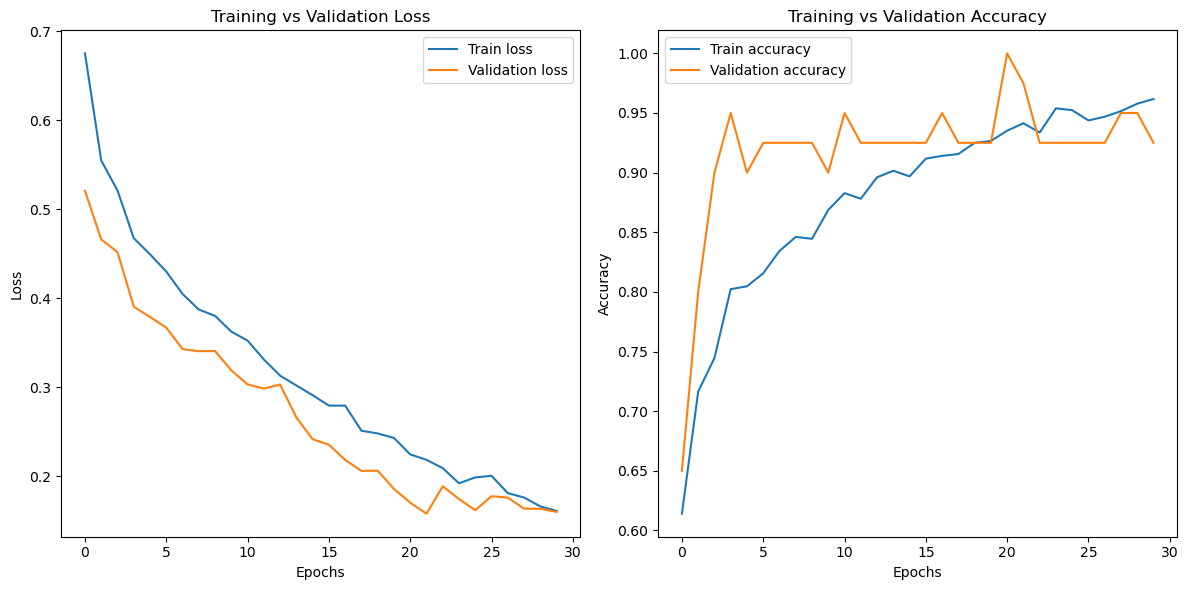

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history['loss'], label='Train loss')
axes[0].plot(history['val_loss'], label='Validation loss')

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history['accuracy'], label='Train accuracy')
axes[1].plot(history['val_accuracy'], label='Validation accuracy')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [53]:
# Evaluation
loss_cnn4, accuracy_cnn4 = cnn4.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cnn4}")
print(f"Test Accuracy: {accuracy_cnn4}")

2/2 [==============================] - 0s 20ms/step - loss: 0.1497 - accuracy: 0.9500
Test Loss: 0.1496601700782776
Test Accuracy: 0.949999988079071


2/2 [==============================] - 0s 23ms/step


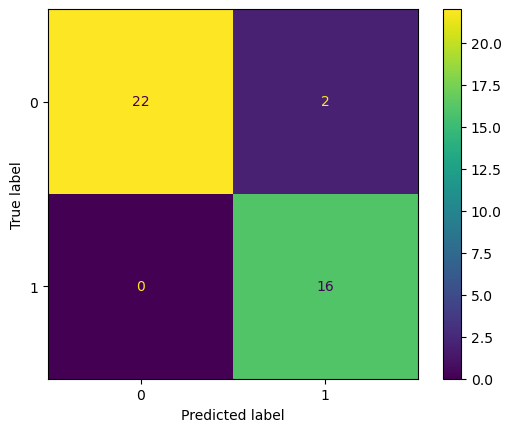

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = cnn4.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

# More evaluation metrics (precision, recall and f1-score)
precision_cnn4 = precision_score(y_true, y_pred, average='macro')
recall_cnn4 = recall_score(y_true, y_pred, average='macro')
f1_cnn4 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision_cnn4}")
print(f"Recall: {recall_cnn4}")
print(f"F1 Score: {f1_cnn4}")

Precision: 0.9444444444444444
Recall: 0.9583333333333333
F1 Score: 0.948849104859335


## **Comparison of Results**

- CNN (iteration 1) accuracy: 75%
- CNN (iteration 2) accuracy: 90%
- CNN (iteration 3) accuracy: 92.5%
- **CNN (iteration 4) accuracy: 95%**

I found out by iteration 3 that transfer learning was really effective, meanwhile by iteration 2, I discovered how good data augmentation was for my dataset (especially because my dataset is very small with only 400 images and 2 classes), since it really benefited from data augmentation.

Combining transfer learning and data augmentation proved to truly be the most effective method out of all the testing I did with each iteration. It led to very little to no overfitting and also lead to a really good accuracy which I'm very happy about!

## Task 3.7: Error Analysis

### A: Wrong Classifications

In [56]:
# Add your code identify and display the misclassified images of your best model
mismatches = np.where(y_pred != y_true)[0]

# Store the wrong predictions
wrong_predictions = X_test[mismatches]

In [57]:
# Number of wrong predictions
len(wrong_predictions)

2

### Showing the wrong predictions with image, true and predicted labels

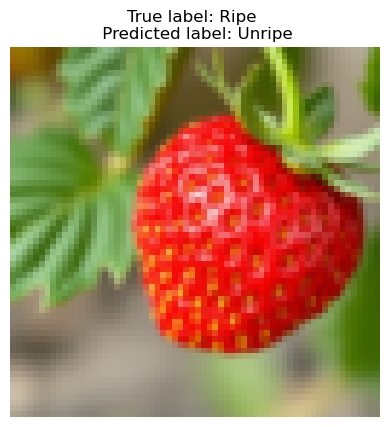

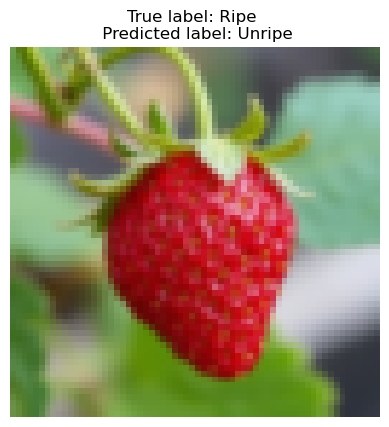

In [58]:
import matplotlib.pyplot as plt

# Class labels
class_labels = {0: "Ripe", 1: "Unripe"} 

for i in mismatches:
    true_label = class_labels[y_true[i]]
    pred_label = class_labels[y_pred[i]]
    
    plt.imshow(X_test[i])
    plt.title(f"True label: {true_label} \n Predicted label: {pred_label}")
    plt.axis("off")
    plt.show()


### B: Identify Error Types

I noticed two key patterns in misclassifications that might be causing some errors to occur.

**Background Confusion**: Misclassifications occur when the model mistakenly focuses on background elements rather than the fruit itself, and thus, misclassifies the fruit in the process.

- **Potential causes**: The background is filled with leaves so the model might confuse the green leaves to be a green unripe fruit and might misclassify it that way.

**Occlusions**: Misclassifications occur when the fruit is partially blocked by leaves or branches, making it difficult for the model to correctly see its full shape. This might result in the model incorrectly classifying the fruit due to slightly incorrect visuals of the fruits shape.

- **Potential causes**: Sometimes a leaf or so goes slightly in front of the fruit and blocks its outline a bit from the side, that could potentially cause the model to trip up and misclassify the fruit.

### C: Categorize Errors

Here is the classification of the error types and the percentages associated with each category.

**Total errors: 2**

- Errors due to Background confusion: 1 (50%)
- Errors due to Occlusions: 1 (50%)

Here is a table below to demonstrate it:

| Error type | Count | Percentage |
|-----------|-----------|-----------|
| Background Confusion | 1 | 50% |
| Occlusions | 1 | 50% |

### D: Propose Improvements

I will now propose improvements based on the quantitative analysis of the errors in the previous section by going through each of the errors, formulating hypotheses for why the errors might have occured, then suggest potential improvements and ways to mitigate those errors.

**Background confusion**

- **Hypothesis**: The model is focussing too much on the background such as leaves which is the same color as unripe fruit, causing the model to be confused and misclassify the fruit.

- **Proposed improvements**: Applying data augmentation more aggressively should help resolve this issue as well as more aggressive zooms to help the model focus more on the fruit rather than the background.

**Occlusions**

- **Hypothesis**: The leaves of the tree in some images prevents the model from seeing the full fruit shape correctly, it might also contribute to putting some hints of green with the fruit which might make it think its slightly unripe when it isn't.

- **Proposed improvements**: A strategy could be to include more images with leaves partially blocking the fruit in the dataset to make the model more resilient to this type of problem.